# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Выполнила Шеневская Влада 


### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [141]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import torch.nn.functional as F

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-27 07:01:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  41.1MB/s    in 5.3s    

2021-10-27 07:01:13 (37.8 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

установим альфу, равную 5

In [ ]:
ridge = Ridge(5.0, random_state=123).fit(X_train, y_train)
rmse_ridge_train = np.sqrt(mean_squared_error(y_train, ridge.predict(X_train)))
rmse_ridge_test = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))
print(f"RMSE train: {rmse_ridge_train}",f"RMSE test: {rmse_ridge_test}", sep='\n')

RMSE train: 9.552822967904525
RMSE test: 9.510160726912835


In [ ]:
ridge.get_params()

{'alpha': 5.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 123,
 'solver': 'auto',
 'tol': 0.001}

подберем гиперпараметр альфа по сетке

In [ ]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]}
grid_search = GridSearchCV(ridge, param_grid, iid=False, cv=5) 
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=5.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=123,
                             solver='auto', tol=0.001),
             iid=False, n_jobs=None,
             param_grid={'alpha': [0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
ridge_best = grid_search.best_estimator_
ridge_best.get_params()

{'alpha': 10.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 123,
 'solver': 'auto',
 'tol': 0.001}

In [ ]:
ridge_best.fit(X_train, y_train)
print(f"RMSE train: {np.sqrt(mean_squared_error(y_train, ridge_best.predict(X_train)))}"
,f"RMSE test: {np.sqrt(mean_squared_error(y_test, ridge_best.predict(X_test)))}", sep='\n')

RMSE train: 9.552822967905987
RMSE test: 9.510160746337895


Для константного признака посмотрим, какой год выпуска песни наиболее частый в обучающей выборке, тем самым выберем лучший константный признак (всегда предсказывать наиболее частый год).

Подсматривать в выборке тестовой мы не можем, поэтому берем тренировочную.

In [6]:
years = np.unique(y_train)
shares = {}
numbers = {}
for i in years:
  shares[i] = np.round((np.sum(y_train == i)/y_train.shape[0]),decimals = 2)
  numbers[i] = np.round((np.sum(y_train == i)),decimals = 2)

sorted_shares = dict(sorted(shares.items(),
                           key=lambda item: item[1],
                           reverse=True))
print(sorted_shares)

{2007: 0.08, 2005: 0.07, 2006: 0.07, 2008: 0.07, 2004: 0.06, 2009: 0.06, 2002: 0.05, 2003: 0.05, 1999: 0.04, 2000: 0.04, 2001: 0.04, 1995: 0.03, 1996: 0.03, 1997: 0.03, 1998: 0.03, 1991: 0.02, 1992: 0.02, 1993: 0.02, 1994: 0.02, 2010: 0.02, 1973: 0.01, 1978: 0.01, 1979: 0.01, 1980: 0.01, 1981: 0.01, 1982: 0.01, 1983: 0.01, 1984: 0.01, 1985: 0.01, 1986: 0.01, 1987: 0.01, 1988: 0.01, 1989: 0.01, 1990: 0.01, 1922: 0.0, 1924: 0.0, 1925: 0.0, 1926: 0.0, 1927: 0.0, 1928: 0.0, 1929: 0.0, 1930: 0.0, 1931: 0.0, 1932: 0.0, 1933: 0.0, 1934: 0.0, 1935: 0.0, 1936: 0.0, 1937: 0.0, 1938: 0.0, 1939: 0.0, 1940: 0.0, 1941: 0.0, 1942: 0.0, 1943: 0.0, 1944: 0.0, 1945: 0.0, 1946: 0.0, 1947: 0.0, 1948: 0.0, 1949: 0.0, 1950: 0.0, 1951: 0.0, 1952: 0.0, 1953: 0.0, 1954: 0.0, 1955: 0.0, 1956: 0.0, 1957: 0.0, 1958: 0.0, 1959: 0.0, 1960: 0.0, 1961: 0.0, 1962: 0.0, 1963: 0.0, 1964: 0.0, 1965: 0.0, 1966: 0.0, 1967: 0.0, 1968: 0.0, 1969: 0.0, 1970: 0.0, 1971: 0.0, 1972: 0.0, 1974: 0.0, 1975: 0.0, 1976: 0.0, 1977: 0.

Визуализируем для наглядности данные

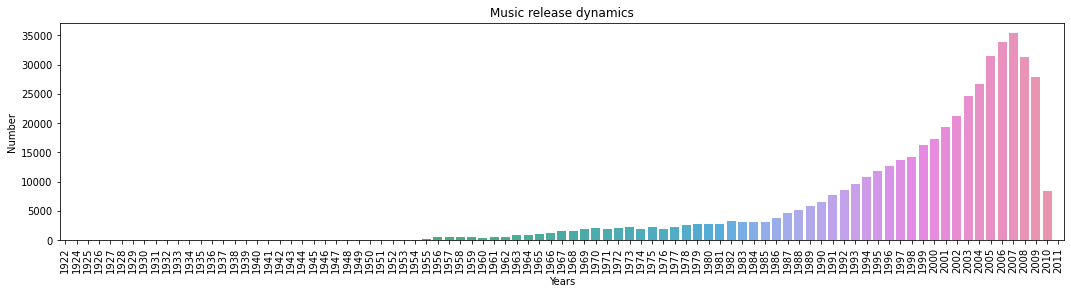

In [ ]:
fig = plt.figure(figsize=(18,4))
sns.barplot(x=list(shares.keys()),y=list(numbers.values()))
plt.xticks(rotation=90)
plt.xlabel("Years")
plt.ylabel('Number')
plt.title("Music release dynamics")
plt.show()

Заметно, что пик приходится на 2007г., тогда как до 1955г. музыка выпускалась в крайне незначительных количествах

Качество при наилучшем константном прогнозе:

In [11]:
print(f"RMSE_const_train: {mean_squared_error(y_train, np.ones(y_train.shape)*(list(sorted_shares)[0]), squared=False)}",
      f"RMSE_const_test: {mean_squared_error(y_test, np.ones(y_test.shape)*(list(sorted_shares)[0]),squared=False)}", sep='\n')

RMSE_const_train: 13.923993812859472
RMSE_const_test: 13.787170630263175


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.02 $ &mdash; 4 балла
- $\text{RMSE} \le 8.92 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.82 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.77 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. **Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.**

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [12]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [13]:
set_random_seed(21)
#фиксируем random_seed

**Предобработка данных**


In [ ]:
print(f"X_train: {np.isnan(X_train).any()}",
      f"X_test: {np.isnan(X_test).any()}",
      f"y_train: {np.isnan(y_train).any()}",
      f"y_test: {np.isnan(y_test).any()}", sep='\n')

X_train: False
X_test: False
y_train: False
y_test: False


Пропусков в данных нет

In [ ]:
X_train.dtype #убедимся, что работаем только с числовыми признаками

dtype('float64')

Масштабируем признаки -- проведем нормализацию, чтобы ускорить обучение модели и улучшить работу с матрицей "объекты-признаки"

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
y_hat_train = sc.fit_transform(np.reshape(y_train, (-1,1)))
y_hat_test = sc.transform(np.reshape(y_test, (-1,1)))

In [142]:
std_y = np.std(y_train)
mean_y = np.mean(y_train) 
#тк StandardScaler предполагает вычитание мат ожидания и деление на стандартное отклонение

In [143]:
sc.scale_ # параметр масштабирования

array([10.93975515])

Отберем признаки только с высокой дисперсией, чтобы не учитывать константные

In [ ]:
features_var = {}
for i in range(90):
    features_var[i+1] =X_train[:, i].var()
print(f"min var: {min(features_var.values())}",f"max var: {max(features_var.values())}", sep="\n")

min var: 0.9999999999999992
max var: 1.0000000000000007


Все признаки с примерно одинаковой дисперсией, не можем среди них отбросить те признаки, что имеют наименьшую диспресию (близкие к константным)

In [ ]:
print(f"Количество лет наблюдений: {len(np.unique(y_train))}") #просто для информации

Количество лет наблюдений: 89


**Нейронная сеть**

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [19]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.utils.data as data_utils

In [20]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.float),  torch.tensor(self.y[idx], dtype=torch.float) ]
# похожую функцию мы писали на семинаре №1    

In [144]:
train_set = MyDataset(X_train, y_hat_train) # y_train нормализованный
train_loader = torch.utils.data.DataLoader(train_set, 
    batch_size=80, 
    shuffle=True, 
    num_workers=1)

test_set = MyDataset(X_test, y_test) # y_test не нормализованный
test_loader = torch.utils.data.DataLoader(test_set, 
    batch_size=80,
    num_workers=1)

criterion = nn.MSELoss()

In [172]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')

    plt.show()

 # функция взята с семинара №3   

In [162]:
NUM_EPOCH=5 # установим для начала такое количество эпох

In [164]:
def trainer(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log, val_loss_log = [], []
    for epoch in range(NUM_EPOCH):
        model.train()
        train_loss = torch.empty(0)
        for imgs, labels in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(imgs)  
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            train_loss = torch.cat((train_loss, torch.unsqueeze(loss,0)))
            train_loss_log.append(train_loss.mean())

        val_loss = torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                pred = model(imgs)
                prediction = pred[:,0]*std_y + mean_y #расскейлили предсказания, чтобы посчитать лосс
                loss = criterion(prediction, labels)
                val_loss = torch.cat((val_loss, torch.unsqueeze(loss,0)))
        val_loss_log.append(val_loss.mean())

        clear_output()
        plot_history(np.sqrt(train_loss_log)*sc.scale_, np.sqrt(val_loss_log), 'loss')

        print('Train loss:', np.sqrt(np.mean(train_loss.detach().numpy()))*sc.scale_) #расскейлим лосс тренировочной выборки
        print('Val loss:', np.sqrt(np.mean(val_loss.detach().numpy())))
        
# функция основана на той, что написали на семинаре №3        

В функции test я хочу выводить и предсказания, и лосс для моей модели

In [170]:
def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - numpy array with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
        loss -     loss for the model
    '''
    model.eval()
    predicts = torch.empty(0)
    val_loss = torch.empty(0)
    for imgs, labels in test_loader:
            pred = model(imgs)
            predc = pred[:,0]*std_y + mean_y 
            predicts = torch.cat((predc, predicts),0)
            loss = criterion(predc, labels)
            val_loss = torch.cat((val_loss, loss.unsqueeze(0))) 
    predicts = predicts.detach().numpy()
    loss = np.sqrt(val_loss.mean().detach().numpy())
    return predicts, loss

Нумерация экспериментов произвольная, тк эксперименты были бесчисленные

**Эксперимент N**

In [27]:
model10 = nn.Sequential( 
        nn.BatchNorm1d(90),    
        nn.Linear(90, 64),
        nn.LeakyReLU(),
        nn.Linear(64,56),
        nn.Dropout(p=0.4),
        nn.Linear(56,32),
        nn.Dropout(p=0.4),
        nn.Linear(32,16),
        nn.LeakyReLU(),
        nn.Linear(16,1)
    )
optimizer10 = torch.optim.Adam(model10.parameters(), lr=0.001, amsgrad=True)

In [174]:
assert test(model10, criterion, test_loader)[0].shape[0] == y_hat_test.shape[0]

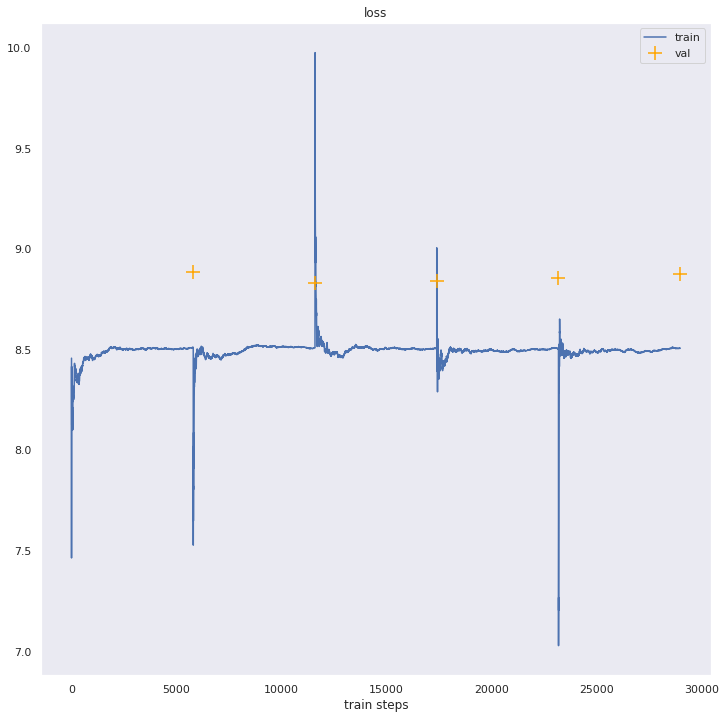

Train loss: [8.50772637]
Val loss: 8.874915


In [165]:
trainer(model10, criterion, optimizer10, train_loader, test_loader)

Потом меняла количество эпох, но качество только ухудшалось, меняла шаг, меняла вероятность в Dropout, переставляла Dropout и BatchNorm1d местами, но кардинально ничего не менялось.

Останавливала раньше 15 эпохи тк видела что качество падало (по этой же причине убрала эксперименты (там кидался ошибкой за приостановку выполнения функции = некрасиво))

**Эксперимент M**

In [176]:
model4 = nn.Sequential( 
        nn.BatchNorm1d(90),     
        nn.Linear(90, 120),
        nn.LeakyReLU(),
        nn.Linear(120, 64),
        nn.Dropout(p=0.3),
        nn.Linear(64,32),
        nn.LeakyReLU(),
        nn.Linear(32,16),
        nn.BatchNorm1d(16),
        nn.Linear(16, 8),
        nn.LeakyReLU(),
        nn.Linear(8,1)
    )
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.001)

In [178]:
assert test(model4, criterion, test_loader)[0].shape[0] == y_hat_test.shape[0]

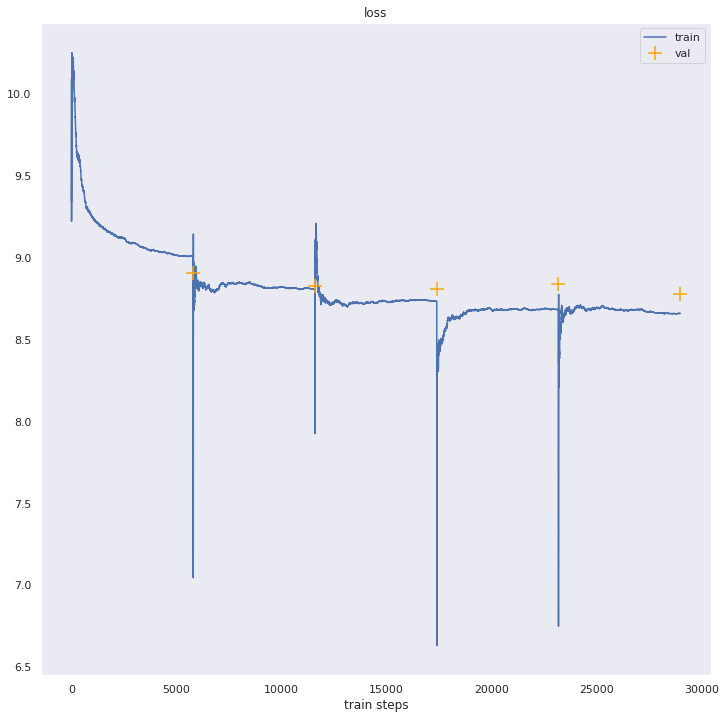

Train loss: [8.66041997]
Val loss: 8.78069


In [179]:
trainer(model4, criterion, optimizer4, train_loader, test_loader) 

In [180]:
NUM_EPOCH= 15 # увеличим количество эпох для всех последующих экспериментов

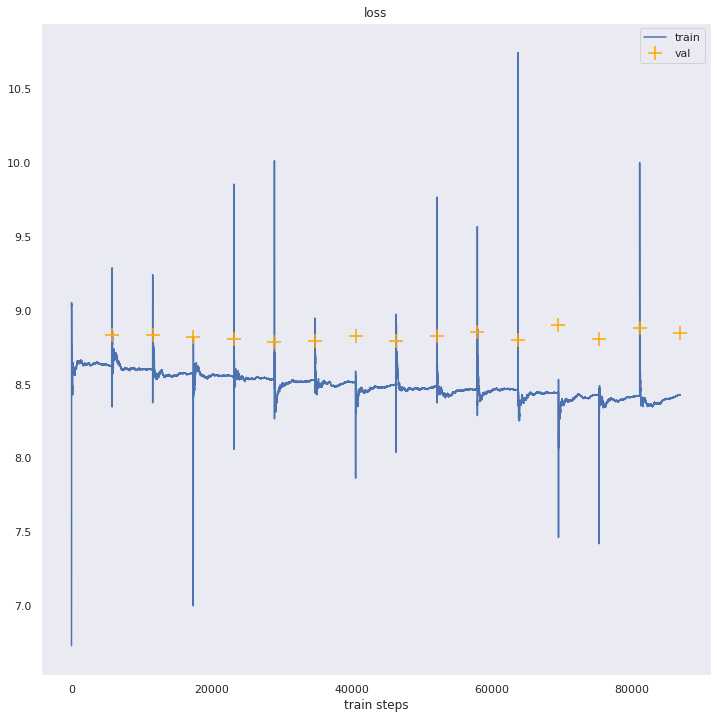

Train loss: [8.42747211]
Val loss: 8.848705


In [181]:
trainer(model4, criterion, optimizer4, train_loader, test_loader) 

In [182]:
optimizer41 = torch.optim.Adam(model4.parameters(), lr=0.0001)

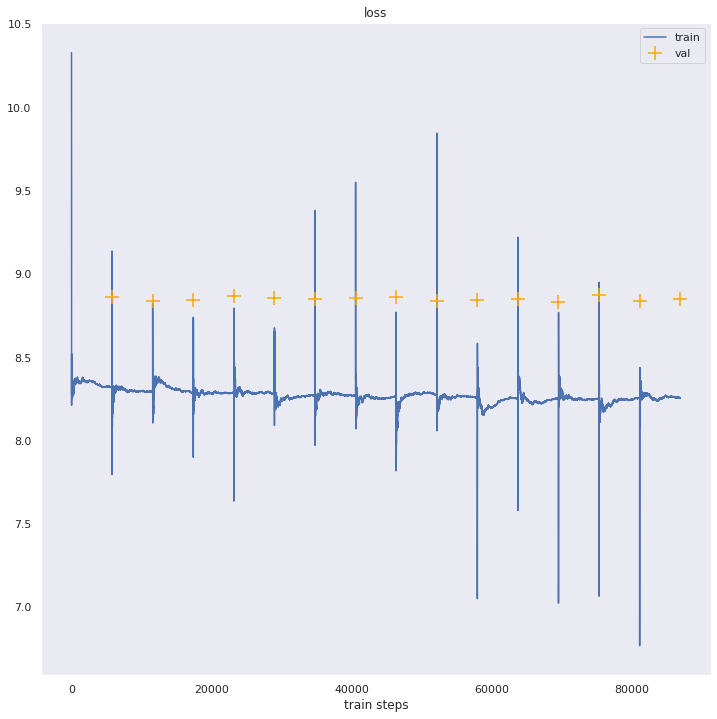

Train loss: [8.25597831]
Val loss: 8.85006


In [183]:
trainer(model4, criterion, optimizer41, train_loader, test_loader) 

Не особо удалось улучшить качество меняя шаг и количество эпох

**Эксперимент Z**

In [201]:
model12 = nn.Sequential(
    nn.BatchNorm1d(90),
    nn.Linear(90, 100),
    nn.LeakyReLU(),       
    nn.Dropout(p=0.2),
    nn.Linear(100, 64),  
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64,32),  
    nn.BatchNorm1d(32),
    nn.LeakyReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(32, 1) 
    )
#добавила побольше комбинаций нормализации и дропаута и увеличила количество нейронов на выходе 1 слоя

optimizer12 = torch.optim.Adam(model12.parameters(), lr=0.001)

In [203]:
assert test(model12, criterion, test_loader)[0].shape[0] == y_test.shape[0]

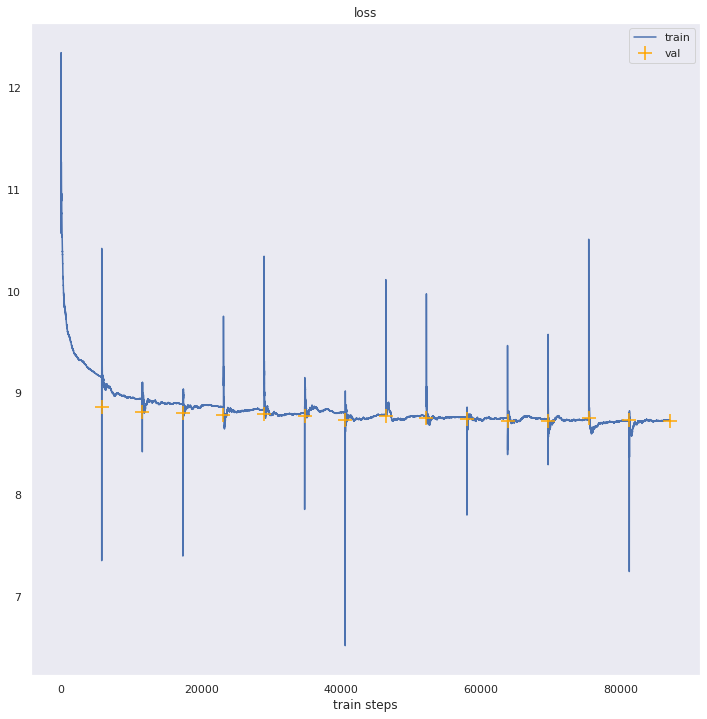

Train loss: [8.73287494]
Val loss: 8.730104


In [202]:
trainer(model12, criterion, optimizer12, train_loader, test_loader) 

In [204]:
print(f"RMSE: {test(model, criterion, test_loader)[1]}")

RMSE: 8.730104446411133


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Было проведено крайне много экспериментов, здесь остались одни из самых последних и удачных, а именно 3 эксперимента. 

В последней модельке, которая по качеству оказалась наилучшей, я в самом начале увеличила количество нейронов до 100, чтобы они новые взаимосвязи находили, потом постепенно снижала, применила чередование нормализации по батчам (BatchNorm1d) и Dropout (зануляет некоторые элементы с вероятностью 0.2). Также в качестве функции активации использовала LeakyRelu, чтобы ускорить обучение в случае, когда сеть сталкивается с константным нулевым градиентом. 

Выбирала количество нейронов кратное 4, потому что вроде как BatchNorm1d просит такого типа ему подавать.

Но последняя модель была выведена методом проб и ошибок, а не из теоретических рассуждений :) 

Обнаружила, что такое сочетание дропаута, функции активации и нормализации пока лучше всего.

До этой в моделях тоже были всевозможные чередования, но качество не было таким высоким + в последней модели я сразу чередовала функцию активации с BatchNorm1d и Dropout перед следующим линейным слоем и наверное это и улучшило качество.

В ходе ~~мучений~~ выполнения задания, я двигала шаг (но как то лучше 0.001 шага не нашлось), изменяла комбинации линейный слой - функция активации - Dropout - BatchNorm1d с разными чередованиями, меняла количество линейных слоев, количество нейронов на входе и выходе, и, ах да, количество эпох для моделей.